# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


# <font style="color:purple">Download the Dataset</font>

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the traffic-sign dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it.

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

In [ ]:
#!wget "https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1" -O Dataset.zip

In [ ]:
#!unzip -q Dataset.zip

In [ ]:
#!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
#!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

In [ ]:
%matplotlib inline

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

# model_zoo has a lots of pre-trained model
from detectron2 import model_zoo

# DefaultTrainer is a class for training object detector
from detectron2.engine import DefaultTrainer
# DefaultPredictor is class for inference
from detectron2.engine import DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg
# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# BoxMode support bounding boxes in different format
from detectron2.structures import BoxMode

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

In [ ]:
def get_regn_plate_dicts(data_root, txt_file):
    dataset_dicts = []
    base_image_filenames = []
    files = os.listdir(os.path.join(data_root, txt_file))
    for file in files:
        base_image_filenames.append(os.path.splitext(file)[0]+".jpg")

    for idx, base_file in enumerate(base_image_filenames):
        record = {}

        image_path = data_root + "/" + txt_file.rpartition('/')[0] + "/" + base_file

        height, width = cv2.imread(image_path).shape[:2]

        record['file_name'] = image_path
        record['image_id'] = idx
        record['height'] = height
        record['width'] = width

        image_name = os.path.splitext(base_file)[0]
        annotation_path = data_root + "/" + txt_file + "/" + image_name + ".txt"
        annotation_rows = []

        with open(annotation_path, "r") as f:
            for line in f:
                temp = line.rstrip().split(" ")
                annotation_rows.append(temp)

        objs = []
        for row in annotation_rows:
            xmin = int(float(row[3]))
            ymin = int(float(row[4]))
            xmax = int(float(row[5]))
            ymax = int(float(row[6]))

            obj= {
                'bbox': [xmin, ymin, xmax, ymax],
                'bbox_mode': BoxMode.XYXY_ABS,
                # alternatively, we can use bbox_mode = BoxMode.XYWH_ABS
                # 'bbox': [xmin, ymin, bwidth, bheight],
                # 'bbox_mode': BoxMode.XYWH_ABS,
                'category_id': 0,
                'iscrowd': 0
            }

            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
data_root = 'Dataset'
train_txt = 'train/Vehicle registration plate/Label'
val_txt = 'validation/Vehicle registration plate/Label'

train_data_name = 'regn_plate_train'
val_data_name = 'regn_plate_val'

thing_classes = ['regn-plate']

output_dir = 'outputs'

def count_lines(fname):
    fnames = os.listdir(fname)
    return len(fnames)

train_img_count = count_lines(os.path.join(data_root, train_txt))

In [ ]:
# Register train and test data

# register train data
DatasetCatalog.register(name=train_data_name,
                        func=lambda: get_regn_plate_dicts(data_root, train_txt))
train_metadata = MetadataCatalog.get(train_data_name).set(thing_classes=thing_classes)

# register test data
DatasetCatalog.register(name=val_data_name,
                        func=lambda: get_regn_plate_dicts(data_root, val_txt))
val_metadata = MetadataCatalog.get(val_data_name).set(thing_classes=thing_classes)

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font>

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



In [ ]:
# Data Visualization

val_data_dict = get_regn_plate_dicts(data_root, val_txt)

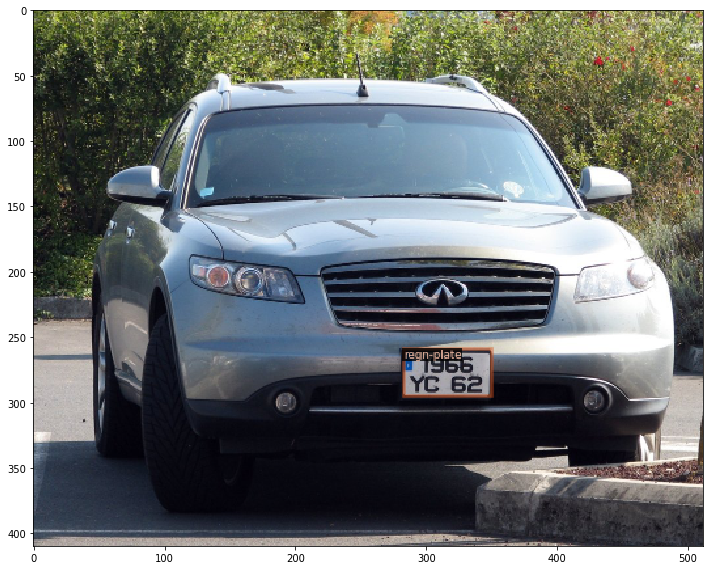

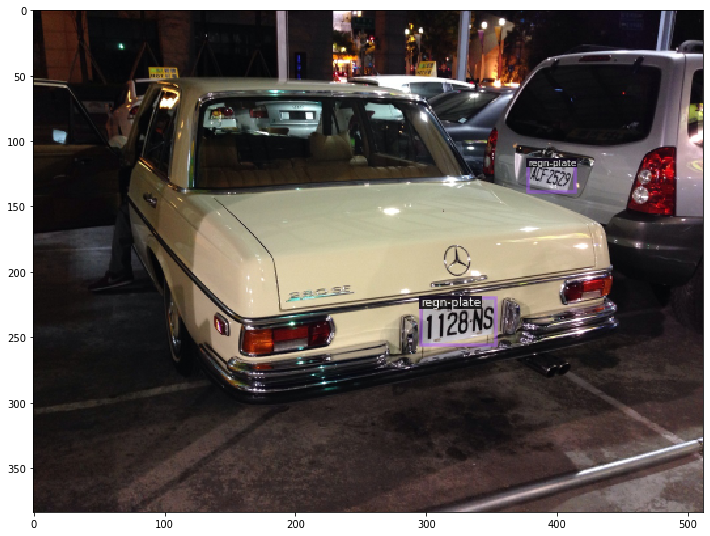

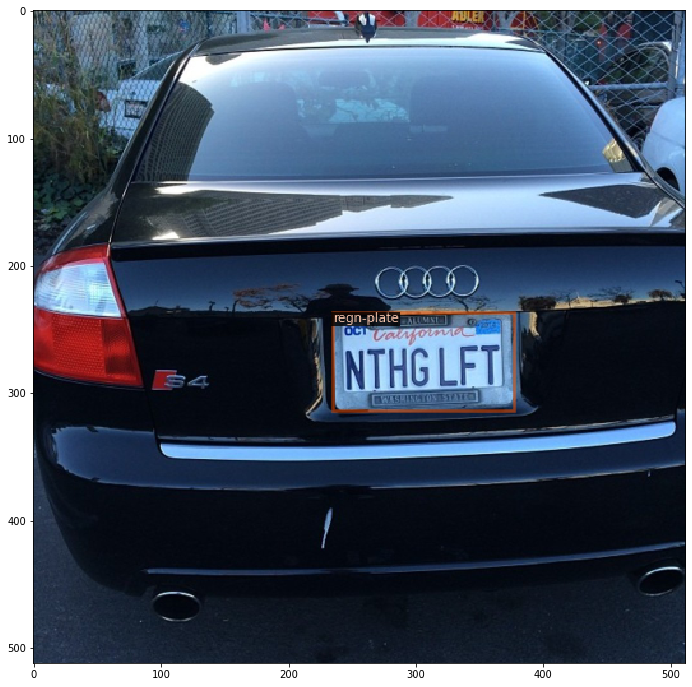

In [ ]:
for d in random.sample(val_data_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=val_metadata,
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

#  <font style="color:green">2. Training [25 Points]</font>

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.**

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

In [ ]:
# detectron2 configuration

# default confugration
cfg = get_cfg()

# update configuration with RetinaNet configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# We have registered the train and test data set with name traffic_sign_train and traffic_sign_test.
# Let's replace the detectron2 default train dataset with our train dataset.
cfg.DATASETS.TRAIN = (train_data_name,)

# No metric implemented for the test dataset, we will have to update cfg.DATASET.TEST with empty tuple
cfg.DATASETS.TEST = ()

Loading config /anaconda/envs/py37_pytorch/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [ ]:
cfg.DATALOADER.NUM_WORKERS = 4

# Update model URL in detectron2 config file
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

# slover configuration

# batch size
cfg.SOLVER.IMS_PER_BATCH = 8

# choose a good learning rate
cfg.SOLVER.BASE_LR = 0.0001

# We need to specify the number of iteration for training in detectron2, not the number of epochs.
# lets convert number of epoch to number or iteration (max iteration)

epoch = 2
max_iter = int(epoch * train_img_count / cfg.SOLVER.IMS_PER_BATCH)


cfg.SOLVER.MAX_ITER = max_iter

In [ ]:
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)
cfg.OUTPUT_DIR = output_dir

# update create ouptput directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir outputs

In [ ]:
# training

# Create a trainer instance with the configuration.
trainer = DefaultTrainer(cfg)

# if rseume=False, because we don't have trained model yet. It will download model from model url and load it
trainer.resume_or_load(resume=False)

# start training
trainer.train()

The tensorboad logs is in the link: https://tensorboard.dev/experiment/51u0JVyzRPSQykdDZLjphw/

#  <font style="color:green">3. Inference [15 Points]</font>

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




In [ ]:
# By default detectron2 save the model with name model_final.pth
# update the model path in configuration that will be used to load the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


# update RetinaNet score threshold
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

cfg.DATASETS.TEST = (val_data_name,)

# create a predictor instance with the configuration (it has our fine-tuned model)
# this predictor does prdiction on a single image
predictor = DefaultPredictor(cfg)

Dataset/validation/Vehicle registration plate/e1925cd0ae28fbd9.jpg
{'instances': Instances(num_instances=1, image_height=654, image_width=1024, fields=[pred_boxes: Boxes(tensor([[450.5044, 378.8170, 591.9321, 452.3627]], device='cuda:0')), scores: tensor([0.7634], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


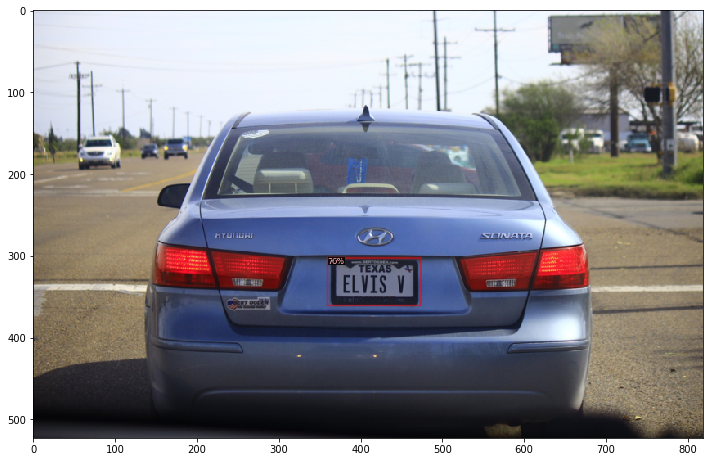

Dataset/validation/Vehicle registration plate/ee047c8ca2cca8a2.jpg
{'instances': Instances(num_instances=1, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[397.1775, 323.2488, 691.5850, 423.4639]], device='cuda:0')), scores: tensor([0.6679], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


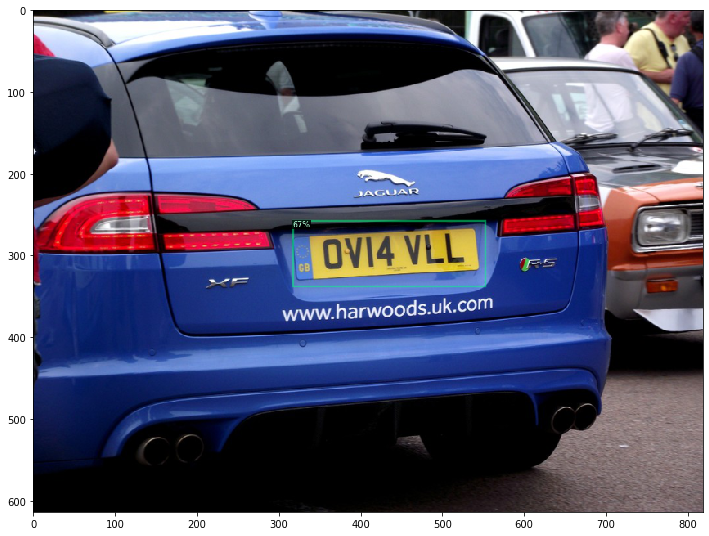

Dataset/validation/Vehicle registration plate/98bcfbc4d3c8abbc.jpg
{'instances': Instances(num_instances=1, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 26.2913, 414.6685,  96.7835, 444.7230]], device='cuda:0')), scores: tensor([0.6890], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


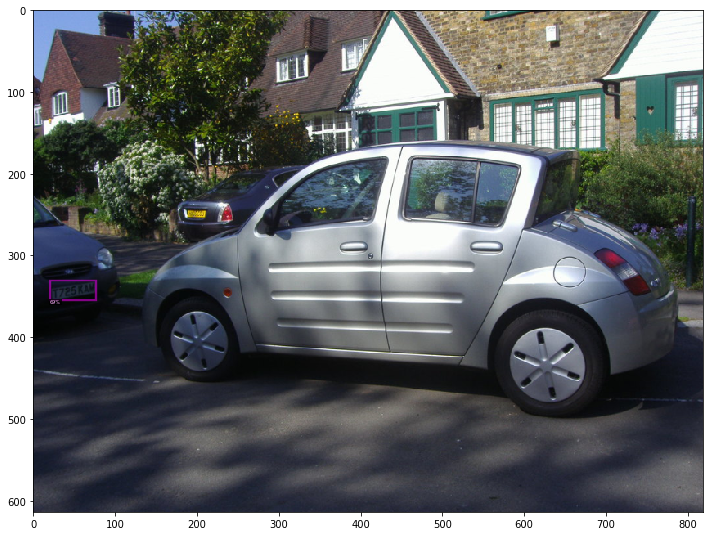

In [ ]:
# Inference

for d in random.sample(val_data_dict, 3):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (12, 12))
    plt.imshow(v.get_image())
    plt.show()

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font>

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



In [ ]:
# create directory for evaluation
eval_dir = os.path.join(cfg.OUTPUT_DIR, 'coco_eval')
os.makedirs(eval_dir, exist_ok=True)

# create evaluator instance with coco evaluator
evaluator = COCOEvaluator(dataset_name=val_data_name,
                          cfg=cfg,
                          distributed=False,
                          output_dir=eval_dir)

# create validation data loader
val_loader = build_detection_test_loader(cfg, val_data_name)

# start validation
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/25 14:17:11 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'regn_plate_val'. Trying to convert it to COCO format ...
[04/25 14:17:11 d2.data.datasets.coco]: Converting dataset annotations in 'regn_plate_val' to COCO format ...)
[04/25 14:17:17 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/25 14:17:17 d2.data.datasets.coco]: Conversion finished, num images: 386, num annotations: 512
[04/25 14:17:17 d2.data.datasets.coco]: Caching annotations in COCO format: outputs/coco_eval/regn_plate_val_coco_format.json
[04/25 14:17:23 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| regn-plate | 512          |
|            |              |
[04/25 14:17:23 d2.data.common]: Serializing 386 elements to byte tensors and concatenating them all ...
[04/25 14:17:23 d2.data.common]: Serialized dataset takes 0.10 MiB
[04/25 14:17:23 d2.evaluation.evaluator]: Start

OrderedDict([('bbox',
              {'AP': 55.314659849241956,
               'AP50': 81.7248847908532,
               'AP75': 67.17189096000254,
               'APs': 18.35201863541748,
               'APm': 65.89064427823602,
               'APl': 66.34516599206216})])

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.**

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

In [ ]:
!wget "https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1" -O projet3-input-video.mp4

--2020-04-25 14:20:23--  https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1
Resolving www.dropbox.com... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/g88o4dx18zpgn8k/projet3-input-video.mp4 [following]
--2020-04-25 14:20:23--  https://www.dropbox.com/s/dl/g88o4dx18zpgn8k/projet3-input-video.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4e632641053fc1adabc0285a1.dl.dropboxusercontent.com/cd/0/get/A2i4DgehrOIRatQFwyBbNewj3AFajzyvVv0jGVvWQc97IjVC828PC-eYyUFepqGYFcy1VWPTYzs-m5Jtpc8BQpoP4OdQezcjTfgYq1ZeoyszBZV_lvvrd6zndubHgNOkSVY/file?dl=1# [following]
--2020-04-25 14:20:23--  https://ucc4e632641053fc1adabc0285a1.dl.dropboxusercontent.com/cd/0/get/A2i4DgehrOIRatQFwyBbNewj3AFajzyvVv0jGVvWQc97IjVC828PC-eYyUFepqGYFcy1VWPTYzs-m5Jtpc8BQpoP4OdQezcjTfgYq1ZeoyszBZV_lvv

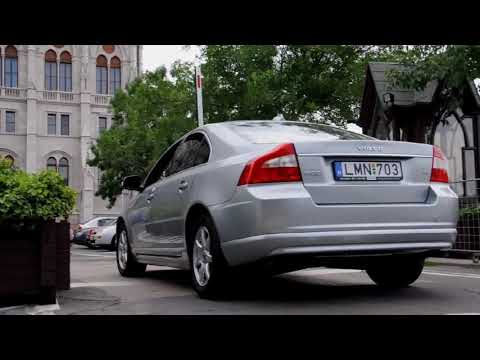

In [ ]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

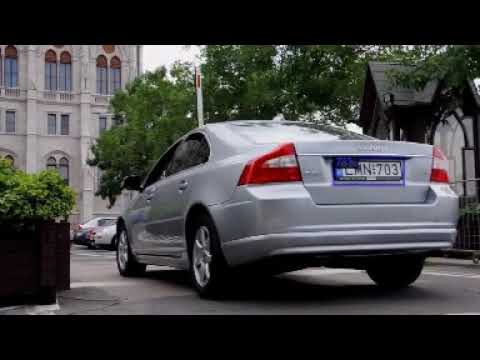

In [ ]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

**You can use the following sample code to read and write a video.**

In [ ]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)

    # Check if camera opened successfully
    if not video.isOpened():
        print("Error opening video file")
        return

    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])

    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc('M','J','P','G'),
        fps=float(frames_per_second),
        frameSize=(1024, 576),
        isColor=True,
    )


    i = 0
    while video.isOpened():


        ret, frame = video.read()
        if ret:
          outputs = predictor(frame)

          v = Visualizer(frame[...,::-1],
                   metadata=val_metadata,
                   scale=0.8
                  )
          v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

          #plt.figure(figsize = (12, 12))
          #plt.imshow(v.get_image())
          #plt.show()


          output_file.write(v.get_image()[...,::-1])
#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
          i += 1
        else:
            break

    video.release()
    output_file.release()

    return

In [ ]:
video_read_write("projet3-input-video.mp4")